# Libraries

In [ ]:
import seaborn as sn
import cv2
import h5py
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets,layers,models,Input,Model
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD, Adadelta
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import os
import sys
import random
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, AveragePooling2D, Cropping2D
from tensorflow.keras.layers import Dropout, Activation, Flatten, Concatenate, Dense, Reshape, Add, PReLU, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD, Adadelta
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.calibration import calibration_curve
from mlxtend.plotting import plot_confusion_matrix

from skimage import io,color

# Definition functions

In [ ]:
def metrics(Y_validation,predictions,log_dir,model_name):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creating confussion matrix
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Plotting cofusion matrix
    snn_df_cm = pd.DataFrame(snn_cm, range(2), range(2))  
    plt.figure(figsize = (9,5))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.savefig(log_dir+model_name+'_CM.png',format='png') 

def get_true_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, log_dir, model_name, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            #plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),fancybox=True, ncol=1)
            plt.legend()
            plt.savefig(log_dir+model_name+'_ROC.png',format='png',bbox_inches="tight")
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title('Precision-Recall Curve')
            #plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),fancybox=True, ncol=1)
            plt.legend()
            plt.savefig(log_dir+model_name+'_PRC.png',format='png',bbox_inches="tight")

def plot_graphs(history, metric, log_dir, model_name):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title("Model "+metric)
    plt.legend([metric, 'val_'+metric])
    plt.savefig(log_dir+model_name+'_'+metric+'.png',format='png',bbox_inches="tight")
    plt.show()

def plot_calibration_curve(y, pred,class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labels[i])
    plt.tight_layout()
    plt.show()

def get_accuracy(y, pred, th=0.5):
    accuracy = 0.0

    TP = get_true_pos(y, pred, th)
    FP = get_false_pos(y, pred, th)
    TN = get_true_neg(y, pred, th)
    FN = get_false_pos(y, pred, th)
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    return accuracy

def get_prevalence(y):
    
    prevalence = 0.0
    prevalence = (1/len(y))*np.sum(y)
    
    return prevalence

def get_sensitivity(y, pred, th=0.5):
    
    sensitivity = 0.0
    TP = get_true_pos(y,pred,th)
    FN = get_false_neg(y,pred,th)

    sensitivity = TP/(TP+FN)
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    specificity = 0.0
    TN = get_true_neg(y,pred,th)
    FP = get_false_pos(y,pred,th)

    specificity = TN/(TN+FP)
    
    return specificity

def get_ppv(y, pred, th=0.5):
    
    PPV = 0.0
    TP = get_true_pos(y,pred,th)
    FP = get_false_pos(y,pred,th)

    PPV = TP/(TP+FP) 
    return PPV

def get_npv(y, pred, th=0.5):
    NPV = 0.0
    
    TN = get_true_neg(y,pred,th)
    FN = get_false_neg(y,pred,th)

    NPV = TN/(TN+FN)    
    return NPV
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=224, W=224):
    
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    if cam.max()!=0:
        print(cam.max())
        cam = cam / cam.max()
    return cam


def compute_gradcam(model,image, labels, layer_name='224_block5_pool'):

    predictions = model.predict(image)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(image[0,:,:,0], cmap='gray')

    j = 1
    for i in range(len(labels)):  
        print(f"Generating gradcam for class {labels[i]}")
        gradcam = grad_cam(model, image, i, layer_name)
        plt.subplot(151 + j)
        plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
        plt.axis('off')
        plt.imshow(image[0,:,:,0],cmap='gray')
        plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
        j += 1


def checkDuplicates(trainDF, devDF, testDF,id_column):
    patientsTrain = set(trainDF[id_column])
    patientsDev = set(devDF[id_column])
    patientsTest = set(testDF[id_column])

    ids = list(patientsTrain.intersection(patientsDev))
    print('# de pacientes de train presentes en dev:', len(ids))

    ids_ = list(patientsTrain.intersection(patientsTest))
    print('# de pacientes de train presentes en test:', len(ids_))
    ids.extend(ids_)

    ids_dev = list(patientsDev.intersection(patientsTest))
    print('# de pacientes de dev presentes en test:', len(ids_dev))

    return ids, ids_dev

def saveNPY(DF,destination, name,path,src_column,W=224,H=224,C_Labels=False):
    src_dir = path
    images = []

    print('reading images...')

    for i in tqdm(DF[src_column]):
        src_file = os.path.join(src_dir, i)
        img = cv2.imread(src_file,-1)
        resized = cv2.resize(img, (W, H))
        if resized.shape==(W,H,4):
            images.append(resized[:,:,0])
        else:
            images.append(resized)

    NPY = np.array(images)
    images_filename = destination+'X_'+name+'.npy'
    np.save(images_filename, NPY)
    if C_Labels:

        labels_ = DF.group.replace(['C', 'N', 'I', 'NI'], [0, 1, 2, 3])
        labels = tf.keras.utils.to_categorical(labels_, num_classes=4)
  
        labels_filename = destination+'/y_'+name+'.npy'
        np.save(labels_filename, labels)
 
    

    print('done!')

def samplewise_preprocessing(images,labels):
    filtered_labels=[]
    processed_images = []
    means = []
    stds = []
    for i in range(images.shape[0]):
        mean = np.mean(images[i])
        std = np.std(images[i])
        if std!=0 and mean != 0:
            means.append(mean)
            stds.append(std)
            processed_images.append((images[i]-mean)/std)
            filtered_labels.append(labels[i])
    
    return np.array(processed_images),np.array(filtered_labels), np.mean(means), np.mean(stds)


def featurewise_preprocessing(images, mean, std):
    processed_images = np.zeros_like(images, dtype=np.float32)
    for i in range(images.shape[0]):
        processed_images[i] = (images[i]-mean)/std
    return processed_images

def min_max_preprocessing(images,labels):
    filtered_labels=[]
    processed_images = []
    for i in range(len(images)):
        try:
          maxi=np.max(images[i])
          mini=np.min(images[i])
          if (maxi-mini)!=0:
            processed_images.append((images[i]-mini)/(maxi-mini))
            filtered_labels.append(labels[i])
        except:
          continue
    return np.array(processed_images),np.array(filtered_labels)

def compute_class_freqs(labels):
   
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels,axis=0)/N
    negative_frequencies = 1-positive_frequencies

    return positive_frequencies, negative_frequencies

def convert_n_CH(train_images,dev_images,test_images,mode='gray'):
    #mode 'gray' expand 1CH
    #mode 'rgb' expand 3CH
    if mode=='gray':
        converted_train=np.expand_dims(train_images,axis=3)
        converted_dev=np.expand_dims(dev_images,axis=3)
        converted_test=np.expand_dims(test_images,axis=3)
    elif mode=='rgb':
        converted_train=np.array([cv2.cvtColor(img,cv2.COLOR_GRAY2BGR) for img in train_images])
        converted_dev=np.array([cv2.cvtColor(img,cv2.COLOR_GRAY2BGR) for img in dev_images])
        converted_test=np.array([cv2.cvtColor(img,cv2.COLOR_GRAY2BGR) for img in test_images])

    return converted_train,converted_dev,converted_test
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y = y)
    class_weight_current=dict(enumerate(class_weight_current.flatten(), 0))
    return class_weight_current

#Models

In [ ]:
def get_model_VGG16_gray():
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

    # Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
    # For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
    # RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

    # getting weights of block1 conv1.
    block1_conv1 = model.get_layer('block1_conv1').get_weights()
    weights, biases = block1_conv1

    # :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
    # convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
    weights = np.transpose(weights, (3, 2, 0, 1))


    kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape

    # Dimensions : [kernel_out_channels, 1 (since grayscale), kernel_rows, kernel_columns]
    grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

      # iterate out_channels number of times
    for i in range(kernel_out_channels):

        # get kernel for every out_channel
        get_kernel = weights[i, :, :, :]

        temp_kernel = np.zeros((3, 3))

        # :get_kernel shape = [3, 3, 3]
        # axis, dims = (0, in_channel), (1, row), (2, col)

        # calculate weighted average across channel axis
        in_channels, in_rows, in_columns = get_kernel.shape

        for in_row in range(in_rows):
            for in_col in range(in_columns):
                feature_red = get_kernel[0, in_row, in_col]
                feature_green = get_kernel[1, in_row, in_col]
                feature_blue = get_kernel[2, in_row, in_col]

            # weighted average for RGB filter
            total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)

            temp_kernel[in_row, in_col] = total


        # :temp_kernel is a 3x3 matrix [rows x columns]
        # add an axis at the end to specify in_channel as 1

        # Second: Add axis at the start of :temp_kernel to make its shape: [1, 3, 3] which is [in_channel, rows, columns]
        temp_kernel = np.expand_dims(temp_kernel, axis=0)

        # Now, :temp_kernel shape is [1, 3, 3]

        # Concat :temp_kernel to :grayscale_weights along axis=0
        grayscale_weights[i, :, :, :] = temp_kernel

      # Dimension of :grayscale_weights is [64, 1, 3, 3]
      # In order to bring it to tensorflow or keras weight format, transpose :grayscale_weights

      # dimension, axis of :grayscale_weights = (out_channels: 0), (in_channels: 1), (rows: 2), (columns: 3)
      # tf format of weights = (rows: 0), (columns: 1), (in_channels: 2), (out_channels: 3)

      # Go from (0, 1, 2, 3) to (2, 3, 1, 0)
    grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0)) # (3, 3, 1, 64)

      # combine :grayscale_weights and :biases
    new_block1_conv1 = [grayscale_weights, biases]


      # Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

      # get weights of all the layers starting from 'block1_conv2'
    vgg16_weights = {}
    for layer in model.layers[2:]:
        if "conv" in layer.name:
            vgg16_weights["224_" + layer.name] = model.get_layer(layer.name).get_weights()

    del model


      # Custom build VGG16
    input = Input(shape=(224, 224, 1), name='224_input')
      # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1), data_format="channels_last", name='224_block1_conv1')(input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='224_block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block1_pool')(x)

      # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block2_pool')(x)

      # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block3_pool')(x)

      # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block4_pool')(x)

      # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv3')(x)
    x = MaxPooling2D((8, 8), strides=(8, 8), name='224_block5_pool')(x)

    base_model = Model(inputs=input, outputs=x)

    base_model.get_layer('224_block1_conv1').set_weights(new_block1_conv1)
    for layer in base_model.layers[2:]:
        if 'conv' in layer.name:
            base_model.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

    x = base_model.output

    for layer in base_model.layers:
        layer.trainable = True

    x = tf.keras.layers.GlobalAveragePooling2D()(x)  
    layers = tf.keras.layers.Flatten()(x)
      #layers = tf.keras.layers.Dense(128,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(1024 ,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense( 512,activation="relu")(layers)
    layers = tf.keras.layers.Dense( 64,activation="relu")(layers)
    predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)

      #Compilador
    model = tf.keras.Model(inputs = base_model.input, outputs=predictions)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) 
    loss='categorical_crossentropy'
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def get_model_VGG19_gray():
      model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

      # Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
      # For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
      # RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

      # getting weights of block1 conv1.
      block1_conv1 = model.get_layer('block1_conv1').get_weights()
      weights, biases = block1_conv1

      # :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
      # convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
      weights = np.transpose(weights, (3, 2, 0, 1))


      kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape

      # Dimensions : [kernel_out_channels, 1 (since grayscale), kernel_rows, kernel_columns]
      grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

      # iterate out_channels number of times
      for i in range(kernel_out_channels):

        # get kernel for every out_channel
        get_kernel = weights[i, :, :, :]

        temp_kernel = np.zeros((3, 3))

        # :get_kernel shape = [3, 3, 3]
        # axis, dims = (0, in_channel), (1, row), (2, col)

        # calculate weighted average across channel axis
        in_channels, in_rows, in_columns = get_kernel.shape

        for in_row in range(in_rows):
          for in_col in range(in_columns):
            feature_red = get_kernel[0, in_row, in_col]
            feature_green = get_kernel[1, in_row, in_col]
            feature_blue = get_kernel[2, in_row, in_col]

            # weighted average for RGB filter
            total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)

            temp_kernel[in_row, in_col] = total


        # :temp_kernel is a 3x3 matrix [rows x columns]
        # add an axis at the end to specify in_channel as 1

        # Second: Add axis at the start of :temp_kernel to make its shape: [1, 3, 3] which is [in_channel, rows, columns]
        temp_kernel = np.expand_dims(temp_kernel, axis=0)

        # Now, :temp_kernel shape is [1, 3, 3]

        # Concat :temp_kernel to :grayscale_weights along axis=0
        grayscale_weights[i, :, :, :] = temp_kernel

      # Dimension of :grayscale_weights is [64, 1, 3, 3]
      # In order to bring it to tensorflow or keras weight format, transpose :grayscale_weights

      # dimension, axis of :grayscale_weights = (out_channels: 0), (in_channels: 1), (rows: 2), (columns: 3)
      # tf format of weights = (rows: 0), (columns: 1), (in_channels: 2), (out_channels: 3)

      # Go from (0, 1, 2, 3) to (2, 3, 1, 0)
      grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0)) # (3, 3, 1, 64)

      # combine :grayscale_weights and :biases
      new_block1_conv1 = [grayscale_weights, biases]


      # Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

      # get weights of all the layers starting from 'block1_conv2'
      vgg19_weights = {}
      for layer in model.layers[2:]:
        if "conv" in layer.name:
          vgg19_weights["224_" + layer.name] = model.get_layer(layer.name).get_weights()

      del model


      # Custom build VGG19
      input = Input(shape=(224, 224, 1), name='224_input')
      # Block 1
      x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1), data_format="channels_last", name='224_block1_conv1')(input)
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name='224_block1_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block1_pool')(x)

      # Block 2
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv1')(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block2_pool')(x)

      # Block 3
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv1')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv2')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv3')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block3_pool')(x)

      # Block 4
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block4_pool')(x)

      # Block 5
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv4')(x)
      x = MaxPooling2D((8, 8), strides=(8, 8), name='224_block5_pool')(x)

      base_model = Model(inputs=input, outputs=x)

      base_model.get_layer('224_block1_conv1').set_weights(new_block1_conv1)
      for layer in base_model.layers[2:]:
        if 'conv' in layer.name:
          base_model.get_layer(layer.name).set_weights(vgg19_weights[layer.name])

      x = base_model.output

      for layer in base_model.layers:
          layer.trainable = True

      x = tf.keras.layers.GlobalAveragePooling2D()(x)  
      layers = tf.keras.layers.Flatten()(x)
      #layers = tf.keras.layers.Dense(128,activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.2)(layers)
      layers = tf.keras.layers.Dense(1024 ,activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.2)(layers)
      layers = tf.keras.layers.Dense( 512,activation="relu")(layers)
      layers = tf.keras.layers.Dense( 64,activation="relu")(layers)
      predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)

      #Compilador
      model = tf.keras.Model(inputs = base_model.input, outputs=predictions)
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) 
      model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
      model.summary()
      return model

#BIMCV datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
new = 'drive/MyDrive'

In [ ]:
Img_dir = new + '/data/DATABASES/CLASSIFICATION'
Wei_dir = new + '/data/WEIGHTS/CLASSIFICATION'

Positive

In [ ]:
P_dir = Img_dir + '/POSITIVE'

Negative Covid Era

In [ ]:
N1_dir = Img_dir + '/NEGATIVE COVID ERA'

Negative Covid Era Without possible covid

In [ ]:
N2_dir = Img_dir + '/NEGATIVE COVID ERA WITHOUT POSSIBLE COVID IMAGES'

Negative Pre-Covid Era

In [ ]:
N3_dir = Img_dir + '/NEGATIVE PRECOVID ERA'

EXP 1 WEIGHTS

In [ ]:
E1_dir = Wei_dir +'/POSITIVE vs NEGATIVE COVID ERA'

EXP 2 WEIGHTS

In [ ]:
E2_dir = Wei_dir +'/POSITIVE vs NEGATIVE COVID ERA WITHOUT POSSIBLE COVID IMAGES'

EXP 3 WEIGHTS

In [ ]:
E3_dir = Wei_dir +'/POSITIVE vs NEGATIVE PRECOVID ERA'

##Experiment 1

###Part C

In [ ]:
C_dir = '/Normal'

In [ ]:
X_train_P = np.load(P_dir + C_dir + '/X_pos_train_C.npy')
X_test_P = np.load(P_dir + C_dir + '/X_pos_test_C.npy')
X_dev_P = np.load(P_dir + C_dir + '/X_pos_dev_C.npy')

In [ ]:
X_train_N = np.load(N1_dir + C_dir + '/X_neg_train_C.npy')
X_test_N = np.load(N1_dir + C_dir + '/X_neg_test_C.npy')
X_dev_N = np.load(N1_dir + C_dir + '/X_neg_dev_C.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="/content/results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

Getting Base Model
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                        

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
#csv_logger = CSVLogger(log_dir + '/csv/'+model_name+'.csv', append=False, separator=';')
history=model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])


Epoch 1/2
138/138 [==============================] - 304s 2s/step - loss: 0.5597 - accuracy: 0.7042 - val_loss: 0.5720 - val_accuracy: 0.7613
Epoch 2/2
138/138 [==============================] - 269s 2s/step - loss: 0.4216 - accuracy: 0.8113 - val_loss: 0.4835 - val_accuracy: 0.7692


In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

Getting Base Model
80150528/80134624 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

Epoch 1/2
138/138 [==============================] - 421s 3s/step - loss: 0.0598 - accuracy: 0.9796 - val_loss: 0.1997 - val_accuracy: 0.9415
Epoch 2/2
138/138 [==============================] - 387s 3s/step - loss: 0.0432 - accuracy: 0.9854 - val_loss: 0.3184 - val_accuracy: 0.8973


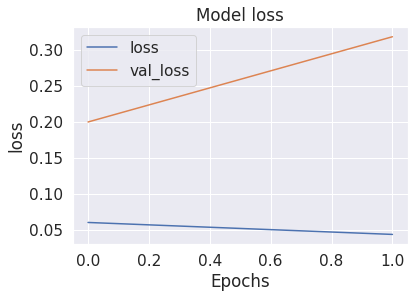

In [ ]:
#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg')

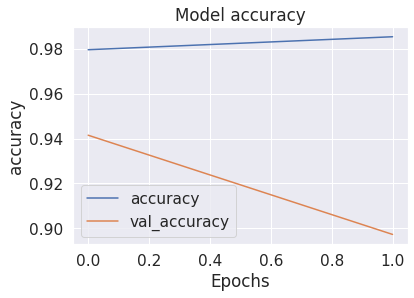

In [ ]:
#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg')

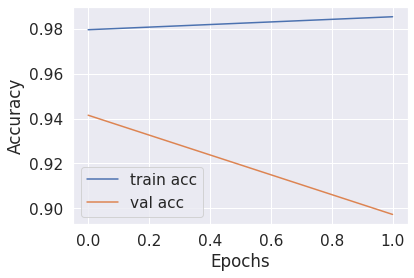

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Prediction

In [ ]:
print("Model VGG 16 Exp 1 Part C")
model = get_model_VGG16_gray()
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

Model VGG 16 Exp 1 Part C
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                 

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

Accuracy: 0.7740281930798804
F1 score: 0.7685638351123427
Recall: 0.7740281930798804
Precision: 0.765227994100969

 clasification report:
               precision    recall  f1-score   support

           0       0.58      0.50      0.54      1228
           1       0.83      0.87      0.85      3454

    accuracy                           0.77      4682
   macro avg       0.71      0.69      0.69      4682
weighted avg       0.77      0.77      0.77      4682


 confusion matrix:
 [[ 617  611]
 [ 447 3007]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,617,3007,447,611,0.802,0.262,0.502,0.871,0.58,0.831,0.782,0.538,0.5
Covid,3007,617,611,447,0.748,0.738,0.871,0.502,0.831,0.58,0.782,0.85,0.5


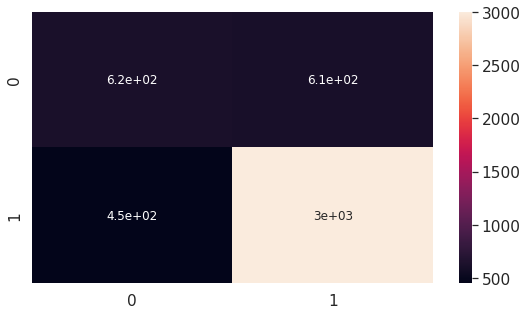

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

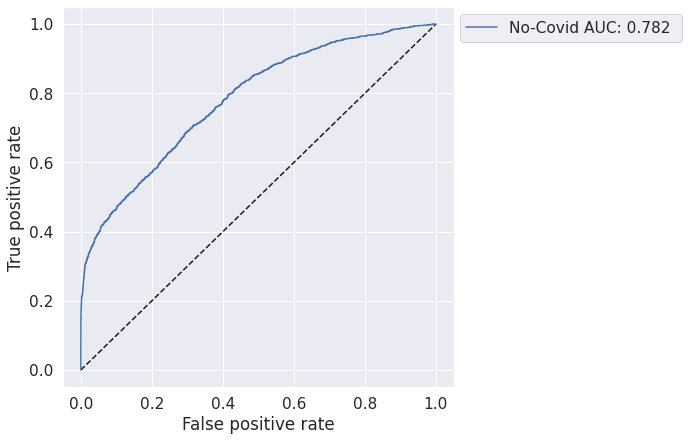

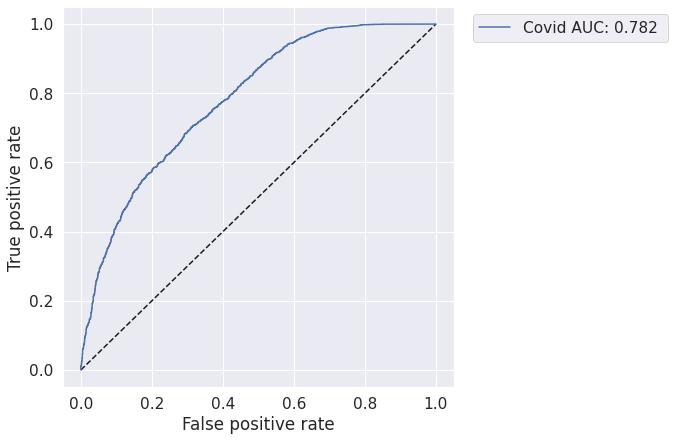

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg',curve='roc')

In [ ]:
print("Model VGG 19 Exp 1 Part C")
model = get_model_VGG19_gray()
model.load_weights(E1_dir+C_dir+'/VGG19_imagenet_posyneg_normal.h5')

Model VGG 19 Exp 1 Part C
80150528/80134624 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

Accuracy: 0.9483126868859462
F1 score: 0.9479903586239842
Recall: 0.9483126868859462
Precision: 0.9479023273473041

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1228
           1       0.96      0.97      0.97      3454

    accuracy                           0.95      4682
   macro avg       0.94      0.93      0.93      4682
weighted avg       0.95      0.95      0.95      4682


 confusion matrix:
 [[1084  144]
 [  98 3356]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1084,3356,98,144,0.958,0.262,0.883,0.972,0.917,0.959,0.979,0.9,0.5
Covid,3356,1084,144,98,0.939,0.738,0.972,0.883,0.959,0.917,0.979,0.965,0.5


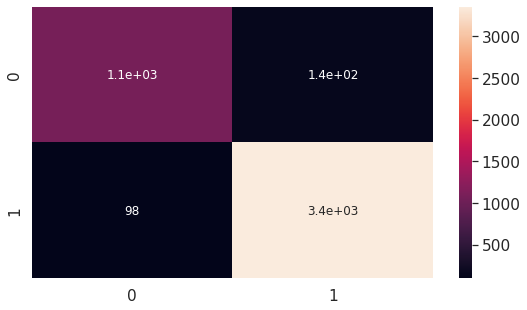

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

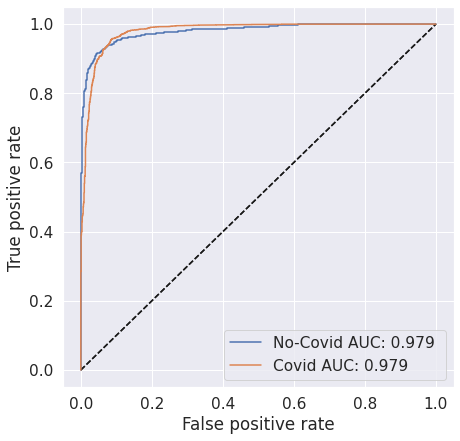

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg',curve='roc')

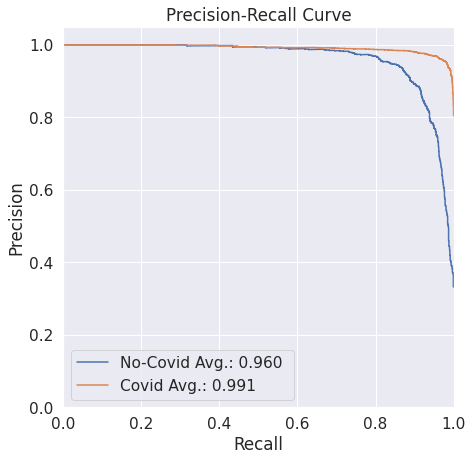

In [ ]:
#PRC curve
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg',curve='prc')

###Part D

In [ ]:
D_dir = '/Segmented'

In [ ]:
X_train_P = np.load(P_dir + D_dir + '/X_pos_Seg_Train.npy')
X_test_P = np.load(P_dir + D_dir + '/X_pos_Seg_Test.npy')
X_dev_P = np.load(P_dir + D_dir + '/X_pos_Seg_Dev.npy')

In [ ]:
X_train_N = np.load(N1_dir + D_dir + '/X_neg_Seg_Train.npy')
X_test_N = np.load(N1_dir + D_dir + '/X_neg_Seg_Test.npy')
X_dev_N = np.load(N1_dir + D_dir + '/X_neg_Seg_Dev.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 1 Part D")
model = get_model_VGG16_gray()
model.load_weights(E1_dir+D_dir+'/VGG16_imagenet_posyneg_seg.h5')

Model VGG 16 Exp 1 Part D
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (Non

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.8989747970952584
F1 score: 0.9005123417590893
Recall: 0.8989747970952584
Precision: 0.9035698918989583

 clasification report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      1228
           1       0.95      0.91      0.93      3454

    accuracy                           0.90      4682
   macro avg       0.86      0.89      0.87      4682
weighted avg       0.90      0.90      0.90      4682


 confusion matrix:
 [[1055  173]
 [ 300 3154]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1055,3154,300,173,0.875,0.262,0.859,0.913,0.779,0.948,0.962,0.817,0.5
Covid,3154,1055,173,300,0.924,0.738,0.913,0.859,0.948,0.779,0.962,0.93,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg_seg',curve='roc')

In [ ]:
print("Model VGG 19 Exp 1 Part D")
model = get_model_VGG19_gray()
model.load_weights(E1_dir+D_dir+'/VGG19_imagenet_posyneg_seg.h5')

Model VGG 19 Exp 1 Part D
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (Non

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.9427595044852627
F1 score: 0.9423704005713399
Recall: 0.9427595044852627
Precision: 0.9422559483228701

 clasification report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1228
           1       0.95      0.97      0.96      3454

    accuracy                           0.94      4682
   macro avg       0.93      0.92      0.93      4682
weighted avg       0.94      0.94      0.94      4682


 confusion matrix:
 [[1069  159]
 [ 109 3345]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1069,3345,109,159,0.953,0.262,0.871,0.968,0.907,0.955,0.978,0.889,0.5
Covid,3345,1069,159,109,0.933,0.738,0.968,0.871,0.955,0.907,0.978,0.961,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_seg',curve='roc')

###Part E

In [ ]:
E_dir = '/Inverted'

In [ ]:
X_train_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Train.npy')
X_test_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Test.npy')
X_dev_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Dev.npy')

In [ ]:
X_train_N = np.load(N1_dir + E_dir + '/X_neg_Seg_i_Train.npy')
X_test_N = np.load(N1_dir + E_dir + '/X_neg_Seg_i_Test.npy')
X_dev_N = np.load(N1_dir + E_dir + '/X_neg_Seg_i_Dev.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg_inv'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg_inv'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 1 Part E")
model = get_model_VGG16_gray()
model.load_weights(E1_dir+E_dir+'/VGG16_imagenet_posyneg_seg_i.h5')

Model VGG 16 Exp 1 Part E
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (Non

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg_inv')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.9327210593763349
F1 score: 0.9316607252330144
Recall: 0.9327210593763349
Precision: 0.9319726396362997

 clasification report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      1228
           1       0.94      0.97      0.96      3454

    accuracy                           0.93      4682
   macro avg       0.92      0.90      0.91      4682
weighted avg       0.93      0.93      0.93      4682


 confusion matrix:
 [[1015  213]
 [ 102 3352]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1015,3352,102,213,0.955,0.262,0.827,0.97,0.909,0.94,0.976,0.866,0.5
Covid,3352,1015,213,102,0.911,0.738,0.97,0.827,0.94,0.909,0.976,0.955,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg_inv',curve='roc')

In [ ]:
print("Model VGG 19 Exp 1 Part E")
model = get_model_VGG19_gray()
model.load_weights(E1_dir+E_dir+'/VGG19_imagenet_posyneg_seg_i.h5')

Model VGG 19 Exp 1 Part E
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_inv')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.9596326356258009
F1 score: 0.9594978511917392
Recall: 0.9596326356258009
Precision: 0.959432897470842

 clasification report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      1228
           1       0.97      0.98      0.97      3454

    accuracy                           0.96      4682
   macro avg       0.95      0.94      0.95      4682
weighted avg       0.96      0.96      0.96      4682


 confusion matrix:
 [[1121  107]
 [  82 3372]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1121,3372,82,107,0.965,0.262,0.913,0.976,0.932,0.969,0.987,0.922,0.5
Covid,3372,1121,107,82,0.955,0.738,0.976,0.913,0.969,0.932,0.987,0.973,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_inv',curve='roc')

##Experiment 2

###Part C

In [ ]:
C_dir = '/Normal'

In [ ]:
X_train_P = np.load(P_dir + C_dir + '/X_pos_train_C.npy')
X_test_P = np.load(P_dir + C_dir + '/X_pos_test_C.npy')
X_dev_P = np.load(P_dir + C_dir + '/X_pos_dev_C.npy')

In [ ]:
X_train_N = np.load(N2_dir + C_dir + '/X_neg_Train_CC.npy')
X_test_N = np.load(N2_dir + C_dir + '/X_neg_Test_CC.npy')
X_dev_N = np.load(N2_dir + C_dir + '/X_neg_Dev_CC.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg2'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg2'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 2 Part C")
model = get_model_VGG16_gray()
model.load_weights(E2_dir+C_dir+'/VGG16_imagenet_posyneg_normal_C.h5')

Model VGG 16 Exp 2 Part C
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.8916992412048746
F1 score: 0.8904103866879799
Recall: 0.8916992412048746
Precision: 0.8895155689662553

 clasification report:
               precision    recall  f1-score   support

           0       0.75      0.71      0.73       895
           1       0.93      0.94      0.93      3454

    accuracy                           0.89      4349
   macro avg       0.84      0.82      0.83      4349
weighted avg       0.89      0.89      0.89      4349


 confusion matrix:
 [[ 632  263]
 [ 208 3246]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,632,3246,208,263,0.903,0.206,0.706,0.94,0.752,0.925,0.936,0.729,0.5
Covid,3246,632,263,208,0.881,0.794,0.94,0.706,0.925,0.752,0.936,0.932,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2',curve='roc')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [ ]:
print("Model VGG 19 Exp 2 Part C")
model = get_model_VGG19_gray()
model.load_weights(E2_dir+C_dir+'/VGG19_imagenet_posyneg_normal_C.h5')

Model VGG 19 Exp 2 Part C
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.9567716716486548
F1 score: 0.95614876569711
Recall: 0.9567716716486548
Precision: 0.9562025284988493

 clasification report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       895
           1       0.96      0.98      0.97      3454

    accuracy                           0.96      4349
   macro avg       0.95      0.92      0.93      4349
weighted avg       0.96      0.96      0.96      4349


 confusion matrix:
 [[ 768  127]
 [  61 3393]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,768,3393,61,127,0.972,0.206,0.858,0.982,0.926,0.964,0.984,0.891,0.5
Covid,3393,768,127,61,0.942,0.794,0.982,0.858,0.964,0.926,0.984,0.973,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2',curve='roc')

###Part D

In [ ]:
D_dir = '/Segmented'

In [ ]:
X_train_P = np.load(P_dir + D_dir + '/X_pos_Seg_Train.npy')
X_test_P = np.load(P_dir + D_dir + '/X_pos_Seg_Test.npy')
X_dev_P = np.load(P_dir + D_dir + '/X_pos_Seg_Dev.npy')

In [ ]:
X_train_N = np.load(N2_dir + D_dir + '/X_neg_Seg_Train_2.npy')
X_test_N = np.load(N2_dir + D_dir + '/X_neg_Seg_Test_2.npy')
X_dev_N = np.load(N2_dir + D_dir + '/X_neg_Seg_Dev_2.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg2_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg2_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 2 Part D")
model = get_model_VGG16_gray()
model.load_weights(E2_dir+D_dir+'/VGG16_imagenet_posyneg_seg_C.h5')

Model VGG 16 Exp 2 Part D
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.9358473212232697
F1 score: 0.9358340341531267
Recall: 0.9358473212232697
Precision: 0.9358208875602991

 clasification report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       895
           1       0.96      0.96      0.96      3454

    accuracy                           0.94      4349
   macro avg       0.90      0.90      0.90      4349
weighted avg       0.94      0.94      0.94      4349


 confusion matrix:
 [[ 755  140]
 [ 139 3315]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,755,3315,139,140,0.936,0.206,0.844,0.96,0.845,0.959,0.966,0.844,0.5
Covid,3315,755,140,139,0.936,0.794,0.96,0.844,0.959,0.845,0.963,0.96,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2_seg',curve='roc')

In [ ]:
print("Model VGG 19 Exp 2 Part D")
model = get_model_VGG19_gray()
model.load_weights(E2_dir+D_dir+'/VGG19_imagenet_posyneg_seg_C.h5')

Model VGG 19 Exp 2 Part D
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.9390664520579444
F1 score: 0.9384235580782436
Recall: 0.9390664520579444
Precision: 0.9381330877131612

 clasification report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.85       895
           1       0.96      0.97      0.96      3454

    accuracy                           0.94      4349
   macro avg       0.91      0.90      0.90      4349
weighted avg       0.94      0.94      0.94      4349


 confusion matrix:
 [[ 738  157]
 [ 108 3346]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,738,3346,108,157,0.95,0.206,0.825,0.969,0.872,0.955,0.968,0.848,0.5
Covid,3346,738,157,108,0.929,0.794,0.969,0.825,0.955,0.872,0.968,0.962,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2_seg',curve='roc')

###Part E

In [ ]:
E_dir = '/Inverted'

In [ ]:
X_train_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Train.npy')
X_test_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Test.npy')
X_dev_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Dev.npy')

In [ ]:
X_train_N = np.load(N2_dir + E_dir + '/X_neg_Seg_Train_i2.npy')
X_test_N = np.load(N2_dir + E_dir + '/X_neg_Seg_Test_i2.npy')
X_dev_N = np.load(N2_dir + E_dir + '/X_neg_Seg_Dev_i2.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg2_inv'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg2_inv'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 2 Part E")
model = get_model_VGG16_gray()
model.load_weights(E2_dir+E_dir+'/VGG16_imagenet_posyneg_seg_i_C.h5')

Model VGG 16 Exp 2 Part E
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2_inv')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.9314785008047827
F1 score: 0.9314215958254561
Recall: 0.9314785008047827
Precision: 0.931366919930534

 clasification report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83       895
           1       0.96      0.96      0.96      3454

    accuracy                           0.93      4349
   macro avg       0.90      0.89      0.90      4349
weighted avg       0.93      0.93      0.93      4349


 confusion matrix:
 [[ 744  151]
 [ 147 3307]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,744,3307,147,151,0.932,0.206,0.831,0.957,0.835,0.956,0.967,0.833,0.5
Covid,3307,744,151,147,0.931,0.794,0.957,0.831,0.956,0.835,0.967,0.957,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2_inv',curve='roc')

In [ ]:
print("Model VGG 19 Exp 2 Part E")
model = get_model_VGG19_gray()
model.load_weights(E2_dir+E_dir+'/VGG19_imagenet_posyneg_seg_i_C.h5')

Model VGG 19 Exp 2 Part E
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2_inv')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.9652793745688664
F1 score: 0.9648188495721132
Recall: 0.9652793745688664
Precision: 0.9649455456200254

 clasification report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       895
           1       0.97      0.99      0.98      3454

    accuracy                           0.97      4349
   macro avg       0.96      0.93      0.95      4349
weighted avg       0.96      0.97      0.96      4349


 confusion matrix:
 [[ 789  106]
 [  45 3409]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,789,3409,45,106,0.979,0.206,0.882,0.987,0.946,0.97,0.988,0.913,0.5
Covid,3409,789,106,45,0.952,0.794,0.987,0.882,0.97,0.946,0.988,0.978,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2_inv',curve='roc')

##Experiment 3

###Part C

In [ ]:
C_dir = '/Normal'

In [ ]:
X_train_P = np.load(P_dir + C_dir + '/X_pos_train_C.npy')
X_test_P = np.load(P_dir + C_dir + '/X_pos_test_C.npy')
X_dev_P = np.load(P_dir + C_dir + '/X_pos_dev_C.npy')

In [ ]:
X_train_N = np.load(N3_dir + C_dir + '/X_train_COVID_neg2.npy')
X_test_N = np.load(N3_dir + C_dir + '/X_test_COVID_neg2.npy')
X_dev_N = np.load(N3_dir + C_dir + '/X_dev_COVID_neg2.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg3'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg3'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 3 Part C")
model = get_model_VGG16_gray()
model.load_weights(E3_dir+C_dir+'/VGG16_imagenet_posypre_normal.h5')

Model VGG 16 Exp 3 Part C
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3',)
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Accuracy: 0.8446961894953656
F1 score: 0.8402542938507662
Recall: 0.8446961894953656
Precision: 0.8404235472765648

 clasification report:
               precision    recall  f1-score   support

           0       0.78      0.65      0.71      1401
           1       0.87      0.92      0.89      3454

    accuracy                           0.84      4855
   macro avg       0.82      0.79      0.80      4855
weighted avg       0.84      0.84      0.84      4855


 confusion matrix:
 [[ 909  492]
 [ 262 3192]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,909,3192,262,492,0.887,0.289,0.649,0.924,0.776,0.866,0.891,0.707,0.5
Covid,3192,909,492,262,0.806,0.711,0.924,0.649,0.866,0.776,0.891,0.894,0.5


In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3',curve='roc')

In [ ]:
print("Model VGG 19 Exp 3 Part C")
model = get_model_VGG19_gray()
model.load_weights(E3_dir+C_dir+'/VGG19_imagenet_posypre_normal.h5')

Model VGG 19 Exp 3 Part C
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
224_input (InputLayer)       [(None, 224, 224, 1)]     0         
_________________________________________________________________
224_block1_conv1 (Conv2D)    (None, 224, 224, 64)      640       
_________________________________________________________________
224_block1_conv2 (Conv2D)    (None, 224, 224, 64)      36928     
_________________________________________________________________
224_block1_pool (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
224_block2_conv1 (Conv2D)    (None, 112, 112, 128)     73856     
_________________________________________________________________
224_block2_conv2 (Conv2D)    (None, 112, 112, 128)     147584    
_________________________________________________________________
224_block2_pool (MaxPooling2 (No

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3',curve='roc')

###Part D

In [ ]:
D_dir = '/Segmented'

In [ ]:
X_train_P = np.load(P_dir + D_dir + '/X_pos_Seg_Train.npy')
X_test_P = np.load(P_dir + D_dir + '/X_pos_Seg_Test.npy')
X_dev_P = np.load(P_dir + D_dir + '/X_pos_Seg_Dev.npy')

In [ ]:
X_train_N = np.load(N3_dir + D_dir + '/X_preC_Seg_Train.npy')
X_test_N = np.load(N3_dir + D_dir + '/X_preC_Seg_Test.npy')
X_dev_N = np.load(N3_dir + D_dir + '/X_preC_Seg_Dev.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg3_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg3_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 3 Part D")
model = get_model_VGG16_gray()
model.load_weights(E3_dir+D_dir+'/VGG16_imagenet_posypre_seg.h5')

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3_seg',curve='roc')

In [ ]:
print("Model VGG 19 Exp 3 Part D")
model = get_model_VGG19_gray()
model.load_weights(E3_dir+D_dir+'/VGG19_imagenet_posypre_seg.h5')

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3_seg',curve='roc')

###Part E

In [ ]:
E_dir = '/Inverted'

In [ ]:
X_train_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Train.npy')
X_test_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Test.npy')
X_dev_P = np.load(P_dir + E_dir + '/X_pos_Seg_i2_Dev.npy')

In [ ]:
X_train_N = np.load(N3_dir + E_dir + '/X_preC_Seg_Train_i.npy')
X_test_N = np.load(N3_dir + E_dir + '/X_preC_Seg_Test_i.npy')
X_dev_N = np.load(N3_dir + E_dir + '/X_preC_Seg_Dev_i.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg3_inv'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg3_inv'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 3 Part E")
model = get_model_VGG16_gray()
model.load_weights(E3_dir+E_dir+'/VGG16_imagenet_posypre_seg_i.h5')

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3_inv')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3_inv',curve='roc')

In [ ]:
print("Model VGG 19 Exp 3 Part E")
model = get_model_VGG19_gray()
model.load_weights(E3_dir+E_dir+'/VGG19_imagenet_posypre_seg_i.h5')

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3_inv')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3_inv',curve='roc')

# Comparison Datasets

Cohen(Positive)

In [ ]:
P_dir = Img_dir + '/POSITIVE COHEN'

Negative(Normal/Pneumonia)

In [ ]:
N_dir = Img_dir + '/NEGATIVE ONLY PNEUMO-NORMAL'

Weights

In [ ]:
W_dir = Wei_dir + '/POSITIVE COHEN vs NEGATIVE ONLY PNEUMO-NORMAL'

###Part C

In [ ]:
X_P = np.load(P_dir + '/X_Covid_Cohen_C.npy')
X_train_P,X_test_P,X_dev_P = np.array_split(X_P,[int(0.7*len(X_P)),int(0.85*len(X_P))])

In [ ]:
X_N1 = np.load(N_dir+'/X_Covid_Normal.npy')
X_train_N1,X_test_N1,X_dev_N1 = np.array_split(X_N1,[int(0.7*len(X_N1)),int(0.85*len(X_N1))])
X_N2 = np.load(N_dir+'/X_Covid_Pneumo.npy')
X_train_N2,X_test_N2,X_dev_N2 = np.array_split(X_N2,[int(0.7*len(X_N2)),int(0.85*len(X_N2))])

In [ ]:
X_train_N=np.concatenate((X_train_N1,X_train_N2))
X_dev_N=np.concatenate((X_dev_N1,X_dev_N2))
X_test_N=np.concatenate((X_test_N1,X_test_N2))

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg_Comp'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 19 Comp Part C")
model = get_model_VGG19_gray()
model.load_weights(W_dir+'/VGG19_Covid_NormC_DataExtra.h5')

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_Comp')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_Comp',curve='roc')

###Part D

In [ ]:
X_P = np.load(P_dir + '/X_Covid_Cohen_C_Seg.npy')
X_train_P,X_test_P,X_dev_P = np.array_split(X_P,[int(0.7*len(X_P)),int(0.85*len(X_P))])

In [ ]:
X_N1 = np.load(N_dir+'/X_Covid_Normal.npy')
X_train_N1,X_test_N1,X_dev_N1 = np.array_split(X_N1,[int(0.7*len(X_N1)),int(0.85*len(X_N1))])
X_N2 = np.load(N_dir+'/X_Covid_Pneumo.npy')
X_train_N2,X_test_N2,X_dev_N2 = np.array_split(X_N2,[int(0.7*len(X_N2)),int(0.85*len(X_N2))])

In [ ]:
X_train_N=np.concatenate((X_train_N1,X_train_N2))
X_dev_N=np.concatenate((X_dev_N1,X_dev_N2))
X_test_N=np.concatenate((X_test_N1,X_test_N2))

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg_seg_Comp'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 19 Comp Part D")
model = get_model_VGG19_gray()
model.load_weights(W_dir+'/VGG19_Covid_Seg_NC_DataExtra.h5')

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_seg_Comp')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_seg_Comp',curve='roc')

###Part E

In [ ]:
X_P = np.load(P_dir + '/X_Covid_Cohen_C_Seg_I.npy')
X_train_P,X_test_P,X_dev_P = np.array_split(X_P,[int(0.7*len(X_P)),int(0.85*len(X_P))])

In [ ]:
X_N1 = np.load(N_dir+'/X_Covid_Normal_Seg_I.npy')
X_train_N1,X_test_N1,X_dev_N1 = np.array_split(X_N1,[int(0.7*len(X_N1)),int(0.85*len(X_N1))])
X_N2 = np.load(N_dir+'/X_Covid_Pneumo_Seg_I.npy')
X_train_N2,X_test_N2,X_dev_N2 = np.array_split(X_N2,[int(0.7*len(X_N2)),int(0.85*len(X_N2))])

In [ ]:
X_train_N=np.concatenate((X_train_N1,X_train_N2))
X_dev_N=np.concatenate((X_dev_N1,X_dev_N2))
X_test_N=np.concatenate((X_test_N1,X_test_N2))

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="../results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg_inv_Comp'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[checkpoint])

#### Prediction

In [ ]:
print("Model VGG 19 Comp Part E")
model = get_model_VGG19_gray()
model.load_weights(W_dir+'/VGG19_Covid_Seg_IC_DataExtra.h5')

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_inv_Comp')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_inv_Comp',curve='roc')